# <ins> Introducción a Kwant </ins>: 

Kwant es un paquete de Python (open source) diseñado para realizar cálculos de transporte cuántico en sistemas de enlace fuerte (*tight-binding*).

![kwant_logo.png](Figs/kwant_logo.png)

Links interesantes se listan a continuación:
- Web de Kwant: https://kwant-project.org/
- Paper New Journal of Physics (citar en el caso de emplear el código): https://iopscience.iop.org/article/10.1088/1367-2630/16/6/063065
- Paper centrado en el algoritmo de "funciones de onda de scattering" empleado en Kwant para el cálculo numérico: https://doi.org/10.1016/j.jcp.2019.05.034

## Algunos tutoriales interesantes son:
- La documentación de la versión 1.5 (¡tiene muchos ejemplos!): https://kwant-project.org/doc/1/tutorial/
- Vídeo-tutorial de 2014 (un poco desactualizado): https://kwant-project.org/doc/kwant-screencast-2014
- Mini-workshop de 2020 (sólo 4h y es muy completo!): https://virtualscienceforum.org/#/quantum-transport-workshop
- Tutorial de 2016 para el March Meeting: https://gitlab.kwant-project.org/kwant/kwant-tutorial-2016

##  <span style="color:orange">Este mini-tutorial es "teórico": </span> 
Hoy intentaremos hacer una introducción muy básica al paquete de Kwant para que, al final de la clase podáis: 
1) Tener una idea básica de los elementos de un código escrito en Python-Kwant.
2) Tener una intuición del algoritmo empleado en el cálculo. 

¡Aprenderemos más detalles **prácticos** a lo largo del curso presencial!

## 1. Kwant es un paquete de Python

Kwant es un paquete de Python que cumple una función específica -> necesitaremos otros paquetes de python auxiliares para los gráficos, para diagonalizar los sistemas, para construir eficientemente los arrays, etc...

En particular emplearemos los paquetes básicos más habituales: <tt>matplotlib, numpy, ~~scipy~~ </tt> (no hoy pero sí en el curso).

In [1]:
## Importamos los módulos básicos:

import kwant #importamos kwant
import matplotlib.pyplot as plt #pyplot para los plots
import numpy as np #numpy para trabajar con vectores
import scipy as sp #scipy para diagonalizaciones, integraciones, etc
import sympy # importamos sympy para que las matrices se muestren mejor en el notebook
sympy.init_printing()

**NOTA**: Si necesitáis refrescar un poco Python, en la carpeta de GettingStarted hay unos tutoriales!
Sólo recordaré cómo se define una función: 

```python
def circle(x, y, x0=0, y0=0, radius=8):
    in_circle = ((x-x0)**2 + (y-y0)**2 < radius**2)
    return in_circle

## Evaluamos la función circle: 
circle(2, 3)     # x, y son argumento obligatorios y deben especificarse en el orden definido. x0, y0, radius son opcionales, si no se especifican tienen el valor por defecto


## 2. Creamos un sistema en Kwant

El workflow habitual de un programa de Kwant es:

    1. Crear un sistema de enlace fuerte “vacío”.
    2. Establecer sus elementos de matriz (onsite) y acoplamientos (*hoppings*).
    3. Conectar los contactos *leads* (sistemas de enlace fuerte con simetría traslacional).
    4. Pasar el sistema finalizado a un solucionador (*solver*).


Los módulos principales de kwant son: 

    kwant.builder – Construcción de sistemas
    kwant.lattice – Redes de Bravais
    ----------------------    
    kwant.plotter – Representación gráfica de sistemas
    kwant.physics – Algoritmos relacionados con la física
    ----------------------
    kwant.solvers – Biblioteca de solucionadores
    kwant.operator – Operadores y observables
    
    


### Vamos a crear este sistema:

Discretizado en una red cuadrada con constante de red $a=1$ y hopping $t =1$. 
Definimos el sistema espacialmente por los parámetros $L, W1, W2$ indicados en la figura.

![QPC_FIG.png](Figs/0-FigSyst.png)

/home/yuriko/anaconda3/envs/Kenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().


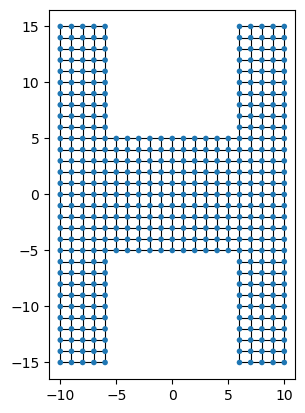

In [2]:
## Creamos nuestro primer sistema en kwant:

# Por simplicidad, fijamos algunos parámetros: 
L, W1, W2 = 10, 10, 30
t = 1

# 1) inicializamos un Builder y definimos una red
a = 1
syst = kwant.Builder()
lat = kwant.lattice.square(a, norbs = 1) # en este caso usaremos una red cuadrada de parámetro 1

# 2) rellenamos el sistema con sitios de la red

# Definimos la forma del QPC
def shapeConstr(pos):
    x, y, = pos
    if abs(x)<= L/2:
        return abs(y)<=W1/2 
    elif L/2 <= abs(x)<= L:
        return abs(y) <= W2/2

# Rellenamos el sistema (onsite)
syst[lat.shape(shapeConstr, (0, 0))] = 0

# Creamos la conexión con los vecinos (hoppings)
syst[lat.neighbors()] = -t

## Antes de continuar podemos plotear el sistema para ver si tiene la forma esperada: 
kwant.plotter.plot(syst); 


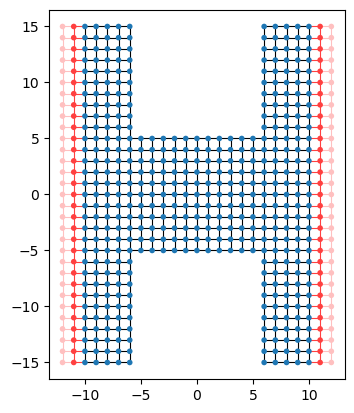

In [3]:
# 3) Creamos el contacto (lead) como un sistema infinito
# en este caso añadimos la simetría traslacional en -x
lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0))) 

def shape_lead(pos):
    x, y = pos
    return abs(y)<= W2/2

lead[lat.shape(shape_lead, (-L,0))] = 0
lead[lat.neighbors()] = -t

# usamos la función reversed para crear un lead en la dirección +x
lead_r = lead.reversed() 

# 4) Pegamos los leads al sistema:
syst.attach_lead(lead);
syst.attach_lead(lead_r);

# 5) finalizamos el sistema:
fsyst = syst.finalized()
kwant.plot(syst);

Por ahora hemos usado, de los módulos listados arriba: 

    [x] kwant.builder – Construcción de sistemas
    [x] kwant.lattice – Redes de Bravais
    ----------------------    
    [x] kwant.plotter – Representación gráfica de sistemas
    kwant.physics – Algoritmos relacionados con la física
    ----------------------
    kwant.solvers – Biblioteca de solucionadores
    kwant.operator – Operadores y observables

## 3. Usamos algunas funciones de *kwant.physics*

El módulo kwant.physics NO es el solver principal de Kwant y (en muchas ocasiones) se pueden emplear otras librerías específicas. En cambio, es muy útil para calcular rápidamente cantidades físicas de interes. 

Por ejemplo, podemos obtener la relación de dispersión de los leads (son sistemas infinitos y por lo tanto tiene un vector k):


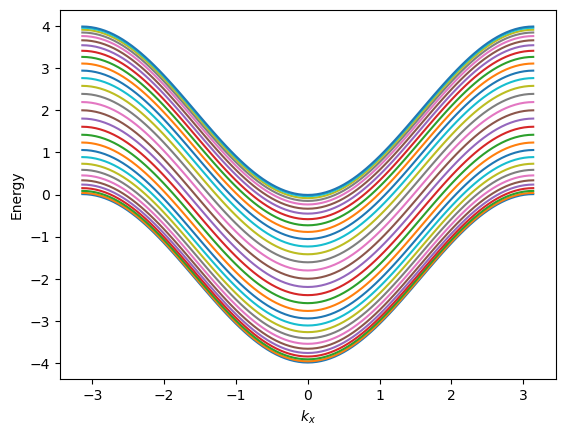

In [4]:
bands = kwant.physics.Bands(fsyst.leads[0])
momenta = np.linspace(-np.pi, np.pi, 101)
energies = [bands(k) for k in momenta]
plt.plot(momenta, energies)
plt.ylabel('Energy')
plt.xlabel('$k_x$')
plt.show()


# Si sólo queremos el plot, una opción todavía más sencilla es usar esta función de kwant.plotter
# kwant.plotter.bands(fsyst.leads[0], show = False);

# 4. Resolvemos el problema de scattering: 

Recordatorio de la matriz de scattering en una barrera:

<img src="Figs/0-barrera.png" width="600">

De forma equivalente, el principal resultado de Kwant es la solución del problema de scattering calculando la propagación desde los leads de los modos de ondas planas a una energía $E$.
Dicho de otro modo, dado un set de modos a energía E en el lead 0, obtenemos la probabilidad de que cada uno de esos  estados se propaguen hasta cada uno de los modos del lead 1. 
Esquemáticamente: 

<img src="Figs/0-2modos.png" width="600">

Como veremos en la teoría, esta probabilidad se relaciona con la corriente (la conductancia) por la fórmula de Landauer-Buttiker, que se puede escribir a temperatura cero:

\begin{equation}
I_p = \frac{e^2}{h} \sum_q G_{pq}  (V_p-V_q)
\end{equation}

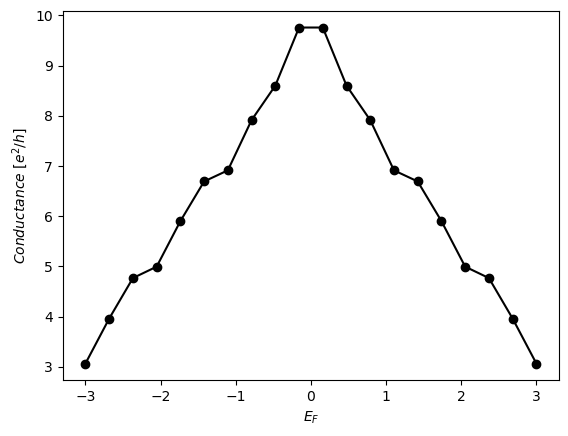

In [5]:
## Calculamos la conductancia para E = -3 hasta E = 3. 

Es = np.linspace(-3, 3, 20)
gs = []
for E in Es:
    S = kwant.solvers.default.smatrix(sys = fsyst, energy = E)
    ## Este solver se abrevia como: 
    # S = kwant.smatrix(sys = fsyst, energy = E)
    gs.append(S.transmission(1, 0))
plt.plot(Es, gs, 'ok-')
plt.ylabel("$Conductance ~[e^2/h]$")
plt.xlabel("$E_F $");

Hemos visto ejemplos de todos los módulos principales excepto kwant.operators.

    [x] kwant.builder – Construcción de sistemas
    [x] kwant.lattice – Redes de Bravais
    ----------------------
    [x] kwant.plotter – Representación gráfica de sistemas
    [x] kwant.physics – Algoritmos relacionados con la física
    ----------------------
    [x] kwant.solvers – Biblioteca de solucionadores
    kwant.operator – Operadores y observables


# 5. Visualizamos algunos observables

Uno de los puntos interesantes de kwant es la posibilidad de visualizar observables con depenencia espacial de forma sencilla

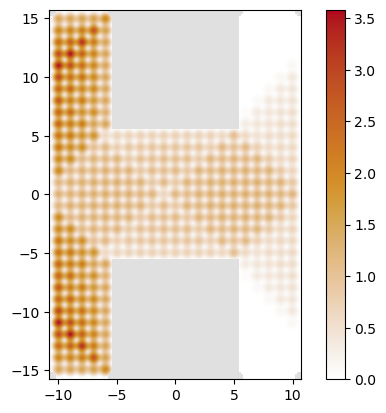

In [6]:
lead_in = 0
psi = kwant.wave_function(fsyst, energy=0)(lead_in)
rho = kwant.operator.Density(fsyst)

kwant.plotter.density(fsyst,
                  np.sum([rho(psi[i]) for i in range(len(psi))], axis = 0));

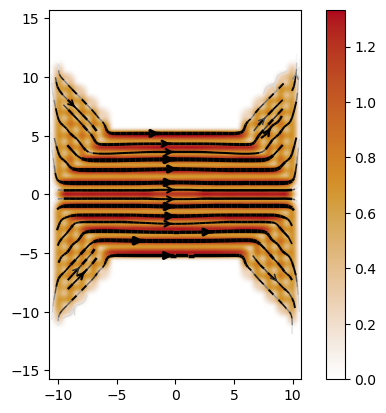

In [7]:
J = kwant.operator.Current(fsyst)
kwant.plotter.current(fsyst,
                  np.sum([J(psi[i]) for i in range(len(psi))], axis = 0));

## ¡Tu turno!
### ¿Qué pasa si cambiamos el tamaño del sistema?

Ideas principiantes:
- Copia el código y modifica L, W1, W2.
- La conductancia cambia con L?
- ¿Qué pasa si aumentamos W1? ¿El caso W1=W2? ¿Si W1>W2?

Ideas avanzadas:
- Puedes definir una función make_syst(L, W1, W2) que te facilite el cambio de parámetros. Explora cómo se modifica la conductancia cambiando L, W1 y W2
- Puedes cambiar la forma modificando la función shapeConstr(). ¿Qué efecto tiene un borde más suave?